In [19]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [20]:
import pandas as pd
import numpy as np
import os
from importlib import reload

import matplotlib.pyplot as plt
import matplotlib
import seaborn 

from sklearn.model_selection import train_test_split
import skimage
from skimage import io
from skimage.transform import resize

# local imports
import data_loader as _load
import classification_metrics as _metrics
import preprocessing as _prepare


In [21]:
%matplotlib inline

Labels:    
 
    - blank for unmentioned    
    - 0 for negative    
    - -1 for uncertain    
    - 1 for positive.    
    
Primary outcomes:

    (a) Atelectasis    
    (b) Cardiomegaly    
    (c) Consolidation    
    (d) Edema    
    (e) Pleural Effusion   

In [22]:
%time
data_path = "/nfs/turbo/umms-indikar/shared/projects/CheXpert/"

train_df = pd.read_csv(f"{data_path}train.csv")
valid_df = pd.read_csv(f"{data_path}valid.csv")

print(f"train set shape: ", train_df.shape)
print(f"valid set shape: ", valid_df.shape)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
train set shape:  (223414, 19)
valid set shape:  (234, 19)


In [23]:
train_df.head()
# valid_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [24]:
train_df.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'],
      dtype='object')

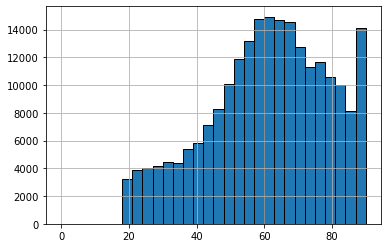

In [25]:
train_df['Age'].hist(edgecolor='black', bins=30)

Text(0.5, 1.0, 'Label counts for Cardiomegaly')

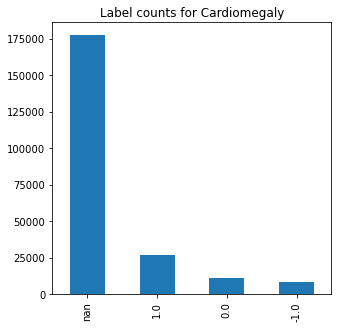

In [26]:
CONDITION = 'Cardiomegaly'
matplotlib.rcParams['figure.figsize'] = 5, 5
cariomelagy_counts = train_df[CONDITION].value_counts(dropna=False)
cariomelagy_counts.plot.bar()
plt.title(f"Label counts for {CONDITION}")

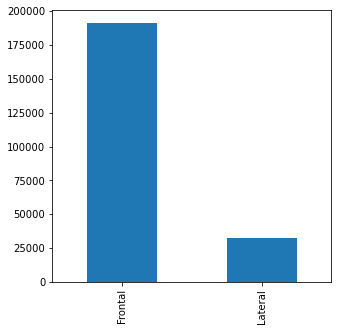

In [27]:
matplotlib.rcParams['figure.figsize'] = 5, 5
view_counts = train_df['Frontal/Lateral'].value_counts(dropna=False)
view_counts.plot.bar()

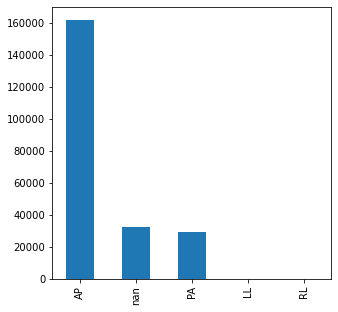

In [28]:
matplotlib.rcParams['figure.figsize'] = 5, 5
view_counts = train_df['AP/PA'].value_counts(dropna=False)
view_counts.plot.bar()

In [29]:
reload(_load)

SAMPLE_SIZE = 100
CONDITION = 'Cardiomegaly'
VIEW_1 = 'Frontal'
# VIEW_2 = 'AP'


# filter out NANs for each condition
tmp_train = train_df[train_df['Frontal/Lateral'] == VIEW_1]
# tmp_train = tmp_train[tmp_train['AP/PA'] == VIEW_2]
tmp_train = tmp_train[tmp_train[CONDITION].notna()].sample(SAMPLE_SIZE).reset_index()
print(f"tmp_train shape {tmp_train.shape}")


# load trainning data
train_path = "/nfs/turbo/umms-indikar/shared/projects/CheXpert/train/"
imgs_train, meta_train = _load.load_images(train_path, tmp_train)
meta_train = pd.concat([tmp_train, meta_train], axis=1)
print(f"train shape {meta_train.shape}")


# load validation data
valid_path = "/nfs/turbo/umms-indikar/shared/projects/CheXpert/valid/"
tmp_valid = valid_df[valid_df['Frontal/Lateral'] == VIEW_1]
# tmp_valid = tmp_valid[tmp_valid['AP/PA'] == VIEW_2]
imgs_valid, meta_valid = _load.load_images(valid_path, tmp_valid)
meta_valid = pd.concat([valid_df, meta_valid], axis=1)
print(f"validation shape {meta_train.shape}")

tmp_train shape (100, 20)
train shape (100, 23)
validation shape (100, 23)


In [30]:
"""
partition trainning data for parameter tuning
"""

X_train, X_test, y_train, y_test = train_test_split(imgs_train, meta_train, test_size=0.33)

print(f"X_train.shape: {len(X_train)}")
print(f"X_test.shape: {len(X_test)}")

print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: 67
X_test.shape: 33
y_train.shape: (67, 23)
y_test.shape: (33, 23)


In [31]:
meta_train.columns

Index(['index', 'Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices', 'patient_id', 'study_number', 'image_name'],
      dtype='object')

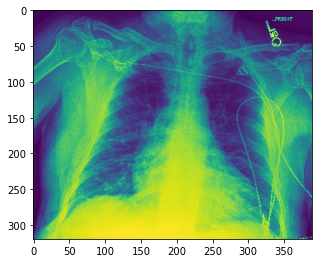

In [32]:
"""
plot raw images
"""

plt.imshow(X_train[0])

prepped train shape: (67, 320, 320, 3)
prepped test shape: (33, 320, 320, 3)

mean:  0.9999691567518451
max:  1.0
min:  0.9999389639124132 



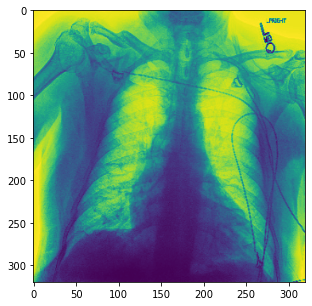

In [43]:
"""
pre-process images
"""
reload(_prepare)

# trainning images
X_train = _prepare.process_X(X_train)
print(f"prepped train shape: {X_train.shape}")

# testing images
X_test = _prepare.process_X(X_test)
print(f"prepped test shape: {X_test.shape}")


rand_img = X_train[0]
print("\nmean: ", rand_img[:, :, 0].mean())
print("max: ", rand_img[:, :, 0].max())
print("min: ", rand_img[:, :, 0].min(), '\n')


plt.imshow(rand_img[:, :, 0])

In [16]:
"""
process the dependant variable
"""  
reload(_prepare)

# trainning labels 
print("TRAIN")
print(y_train[CONDITION].value_counts(normalize=True))
y_train = _prepare.process_Y(y_train, 'Cardiomegaly')
print(y_train.shape)
print()

# testing labels
print("TEST")
print(y_test[CONDITION].value_counts(normalize=True))
y_test = _prepare.process_Y(y_test, 'Cardiomegaly')
print(y_test.shape)


TRAIN
 1.0    0.626866
-1.0    0.238806
 0.0    0.134328
Name: Cardiomegaly, dtype: float64
(67, 2)

TEST
 1.0    0.696970
-1.0    0.151515
 0.0    0.151515
Name: Cardiomegaly, dtype: float64
(33, 2)


In [17]:
batch_size = 36
epochs = 3
retrain_last = 10

# image input shape
input_tensor = Input(shape=(320, 320, 3))


# # start with densenet 
# base_model = tf.keras.applications.DenseNet121(weights=None, 
#                                                weights='imagenet', 
#                                                input_tensor=input_tensor,
#                                                include_top=True)

# resnet model
base_model = tf.keras.applications.ResNet152V2(weights='imagenet', 
                                               input_tensor=input_tensor,
                                               include_top=True)


# connect the base model to a final set of layers
x = base_model.output
x = Dense(1024, activation='relu')(x)
# and a binary logistic output layer
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, 
              outputs=predictions)

# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers[:-retrain_last]:
    layer.trainable = False
    
# set adam optimizer per paper
# except learning rate
opt = tf.keras.optimizers.Adam(learning_rate=0.00001,
                               beta_1=0.9,
                               beta_2=0.999)
    
# compile and train
model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=['AUC'])

model.fit(x=X_train, 
          y=y_train,
          shuffle=True,
          validation_split=0.1,
          batch_size=batch_size, 
          epochs=epochs)

Epoch 1/3


KeyboardInterrupt: 

In [ ]:
"""
how do we do on the test set?
"""

reload(_metrics)

_metrics.get_classification_metrics(model, X_test, y_test)

In [ ]:
"""
how do we do on the validation set?
"""